In [1]:
using Revise

In [2]:
using MeshCatMechanisms
using MeshCat
using RigidBodyDynamics
using RigidBodySim
using Flux
using JLD2
using Plots; gr()
using LCPSim
using LearningMPC
using LearningMPC.Models
using DataFrames
using Blink

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/9db0e137604e898c25f194d972715156bd46cb81-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/9db0e137604e898c25f194d972715156bd46cb81-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

INFO: Loading HttpServer methods...


In [3]:
vis = Visualizer()
open(vis, Window())

Blink.AtomShell.Window(1, Blink.AtomShell.Electron(Process(`/home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/deps/atom/electron /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/src/AtomShell/main.js port 7472`, ProcessRunning), TCPSocket(RawFD(64) active, 0 bytes waiting), Dict{String,Any}(Pair{String,Any}("callback", Blink.#1))), Blink.Page(1, WebSockets.WebSocket{TCPSocket}(TCPSocket(RawFD(55) active, 0 bytes waiting), true, CONNECTED::WebSockets.ReadyState = 1), Dict{String,Any}(Pair{String,Any}("webio", WebIO.#111),Pair{String,Any}("callback", Blink.#1)), Future(1, 1, 1, Nullable{Any}(true))))

In [4]:
delete!(vis)

robot = CartPole(add_contacts=true)
mvis = MechanismVisualizer(robot, vis)

MeshCatMechanisms.MechanismVisualizer{RigidBodyDynamics.MechanismState{Float64,Float64,Float64,TypeSortedCollections.TypeSortedCollection{Tuple{Array{RigidBodyDynamics.Joint{Float64,RigidBodyDynamics.Fixed{Float64}},1},Array{RigidBodyDynamics.Joint{Float64,RigidBodyDynamics.Prismatic{Float64}},1},Array{RigidBodyDynamics.Joint{Float64,RigidBodyDynamics.Revolute{Float64}},1}},3}},MeshCat.Visualizer}(MechanismState{Float64, Float64, Float64, …}(…), MeshCat Visualizer with path /meshcat, 5)

In [80]:
interval_net, lqrsol = jldopen("cartpole-interval.jld2") do file
    file["net"], file["lqrsol"]
end
interval_net_mpc = LearningMPC.mpc_controller(robot, LearningMPC.LearnedCost(lqrsol, interval_net), Δt=0.025)

full_mpc_controller = MPCController(robot, MPCParams(robot), lqrsol, [lqrsol]);

policy_net = jldopen("cartpole-mimic.jld2") do file
    file["net"]
end

policy_net_controller = let net = policy_net
    function (τ, t, x)
        τ .= Flux.Tracker.data(net(LearningMPC.qv(x)))
    end
end

lqr_mpc = LearningMPC.mpc_controller(robot, lqrsol, Δt=0.025);

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [81]:
@load "library.jld2" training

1-element Array{Symbol,1}:
 :training

In [82]:
training[indmax([d[1].mip.objective_bound for d in training])]

(LearningMPC.Sample{4,2,Float64}([0.423694, -0.941235, 0.469219, -4.92361], [-20.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0], LearningMPC.WarmstartCostRecord{Float64}(Nullable{Float64}(33372.3), Nullable{Float64}(58198.8)), LearningMPC.MIPResults
  solvetime_s: Float64 3.0152459144592285
  objective_value: Float64 32914.17837038444
  objective_bound: Float64 26016.170908094307
),)

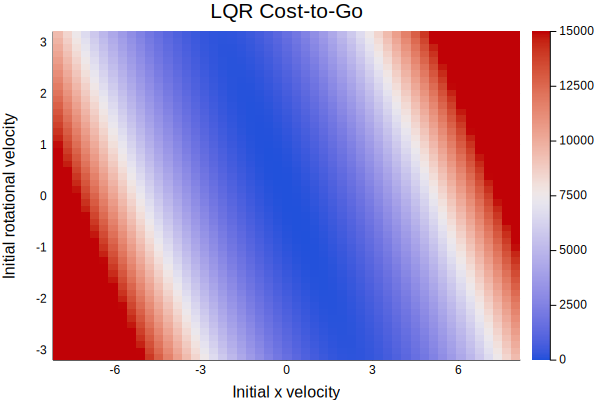

In [89]:
xx = linspace(-8, 8, 51)
yy = linspace(-π, π, 51)
getstate(x, y) = [0, 0, x, y]
plt = heatmap(xx, yy, (x, y) -> (getstate(x, y) - lqrsol.x0)' * lqrsol.S * (getstate(x, y) - lqrsol.x0), 
    color=:coolwarm,
    clim=(0, 15000))
title!(plt, "LQR Cost-to-Go")
xlabel!(plt, "Initial x velocity")
ylabel!(plt, "Initial rotational velocity")
savefig(plt, "lqr_cost_to_go.pdf")
plt

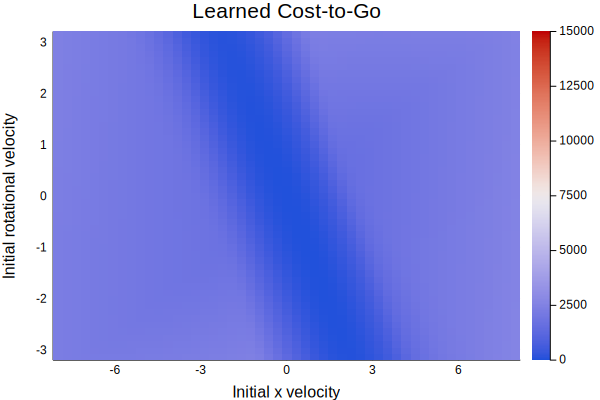

In [90]:
plt = heatmap(xx, yy, (x, y) -> Flux.Tracker.data(interval_net(getstate(x, y)))[], color=:coolwarm,
    clim=(0, 15000))
title!(plt, "Learned Cost-to-Go")
xlabel!(plt, "Initial x velocity")
ylabel!(plt, "Initial rotational velocity")
savefig(plt, "learned_cost_to_go.pdf")
plt

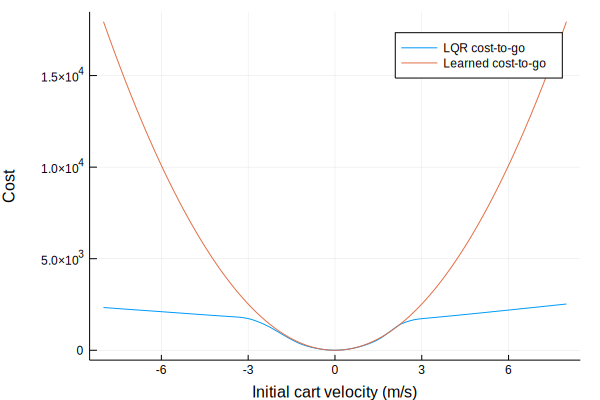

In [97]:
# d = [x for x in training if norm(x[1].state[[1,2,4]]) < 0.1]
# plt = scatter([s[1].state[3] for s in d], [s[1].mip.objective_value for s in d])
plt = plot()
xx = linspace(-8, 8, 101)
yy = [Flux.Tracker.data(interval_net(getstate(xi, 0)))[1] for xi in xx]
plot!(plt, xx, yy, label="LQR cost-to-go")
yy = [getstate(xi, 0)' * lqrsol.S * getstate(xi, 0) for xi in xx]
plot!(plt, xx, yy, label="Learned cost-to-go")
xlabel!(plt, "Initial cart velocity (m/s)")
ylabel!(plt, "Cost")
savefig(plt, "lqr_vs_learned_cost_1d.pdf")
savefig(plt, "lqr_vs_learned_cost_1d.png")
plt

In [76]:
state = nominal_state(robot)
set_velocity!(state, [8.0, 0])
problem = LearningMPC.simulation_problem(state, interval_net_mpc, 0.01, 6.0)
solution = RigidBodySim.solve(problem, Tsit5(), abs_tol=1e-8, dt=1e-6)
setanimation!(mvis, solution)

true

In [77]:
policies = [
            (interval_net_mpc, "MPC + Learned Interval"),
            (lqrsol, "LQR"), 
            (lqr_mpc, "MPC + LQR cost"),
            (policy_net_controller, "Policy Net"), 
]

tables = map(policies) do args
    controller, label = args
    LearningMPC.run_evaluations(
        controller,
        label,
        robot,
        lqrsol,
        [(1, [0])],
        [(1, linspace(-8, 8, 11)), (2, linspace(-π, π, 11))]; 
        mvis=mvis,
        horizon=400)
end
cost_table = vcat(tables...)

Progress: 100%|█████████████████████████████████████████| Time: 0:04:45
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:04:44
Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


,controller,q0,v0,Δt,horizon,qf,vf,running_cost,terminal_cost
1,MPC + Learned Interval,"[0.0, 0.0]","[-8.0, -3.14159]",0.01,400,"[-2.47274, 1.80723]","[-1.26819e-9, -1.27711e-10]",1668.12,8533.5
2,MPC + Learned Interval,"[0.0, 0.0]","[-6.4, -3.14159]",0.01,400,"[-2.43395, 1.93768]","[-6.81356e-11, 1.87486e-11]",1770.32,9939.12
3,MPC + Learned Interval,"[0.0, 0.0]","[-4.8, -3.14159]",0.01,400,"[-0.164927, 0.0450995]","[-0.250648, 0.0484243]",139.407,27.8448
4,MPC + Learned Interval,"[0.0, 0.0]","[-3.2, -3.14159]",0.01,400,"[-0.355657, 0.0710297]","[0.229625, -0.105489]",97.9726,34.004
5,MPC + Learned Interval,"[0.0, 0.0]","[-1.6, -3.14159]",0.01,400,"[-0.368355, 0.0693175]","[-0.07042, 0.111518]",74.0798,45.7849
6,MPC + Learned Interval,"[0.0, 0.0]","[0.0, -3.14159]",0.01,400,"[-0.247417, -0.0999242]","[0.338905, -0.0609189]",67.3061,44.6816
7,MPC + Learned Interval,"[0.0, 0.0]","[1.6, -3.14159]",0.01,400,"[-0.223413, 0.0397572]","[0.0755676, -0.067359]",8.15974,14.9828
8,MPC + Learned Interval,"[0.0, 0.0]","[3.2, -3.14159]",0.01,400,"[-0.135157, -0.0275987]","[-0.112301, 0.107492]",9.1689,22.9887
9,MPC + Learned Interval,"[0.0, 0.0]","[4.8, -3.14159]",0.01,400,"[-0.131253, -0.0426648]","[-0.246718, 0.247838]",61.1199,36.6498
10,MPC + Learned Interval,"[0.0, 0.0]","[6.4, -3.14159]",0.01,400,"[-0.211626, 0.0306881]","[-0.193688, 0.154163]",78.1205,24.8156


In [99]:
@save "cost_table.jld2" cost_table

In [110]:
function cost_heatmap(table, label; clim=(0, 5000), feature=:running_cost)
    xs = sort(unique(row[:v0][1] for row in eachrow(table) if row[:controller] == label))              
    ys = sort(unique(row[:v0][2] for row in eachrow(table) if row[:controller] == label))
    zs = zeros(length(ys), length(xs))
    for row in eachrow(table)
        if row[:controller] == label
            x = row[:v0][1]
            y = row[:v0][2]
            ix = findfirst(k -> k == x, xs)
            iy = findfirst(k -> k == y, ys)
            zs[iy, ix] = row[feature][1]
        end
    end

    plt = heatmap(xs, ys, zs, clim=clim, color=:coolwarm, aspect_ratio=8/π)
    xlabel!(plt, "Initial x velocity")
    ylabel!(plt, "Initial rotational velocity")
    title!(plt, label)
    plt
end
                                
                                

cost_heatmap (generic function with 1 method)

In [126]:
function success_heatmap(table, label, q_threshold=π/8, v_threshold=π/8)
    xs = sort(unique(row[:v0][1] for row in eachrow(table) if row[:controller] == label))              
    ys = sort(unique(row[:v0][2] for row in eachrow(table) if row[:controller] == label))
    zs = zeros(Bool, length(ys), length(xs))
    for row in eachrow(table)
        if row[:controller] == label
            x = row[:v0][1]
            y = row[:v0][2]
            ix = findfirst(k -> k == x, xs)
            iy = findfirst(k -> k == y, ys)
            success = (isapprox(row[:qf][2], 0, atol=q_threshold) && 
                isapprox(row[:vf][2], 0, atol=v_threshold))
            zs[iy, ix] = success
        end
    end

    plt = heatmap(xs, ys, zs, colorbar=false, aspect_ratio=8/π)
    xlabel!(plt, "Initial x velocity")
    ylabel!(plt, "Initial rotational velocity")
    title!(plt, label)
    plt
end
                                
   

success_heatmap (generic function with 3 methods)

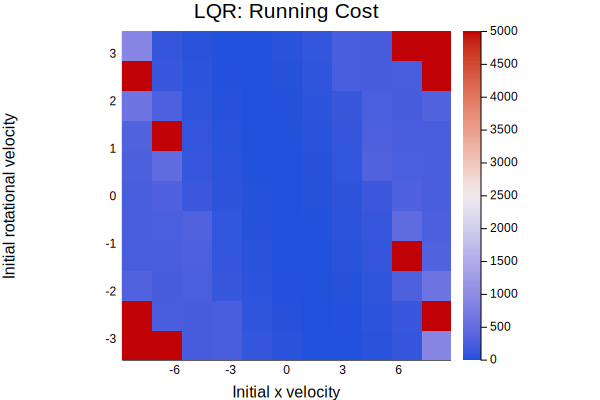

In [127]:
label = "LQR"
plt = cost_heatmap(cost_table, label)
title!(plt, "$label: Running Cost")
savefig(plt, "lqr_running_cost.pdf")
plt

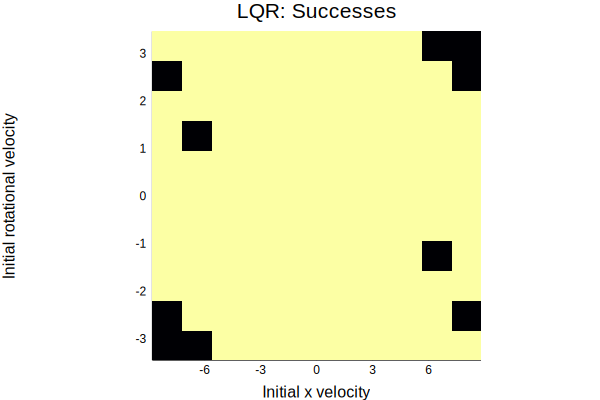

In [128]:
plt = success_heatmap(cost_table, label)
title!(plt, "$label: Successes")
savefig(plt, "lqr_successes.pdf")
plt

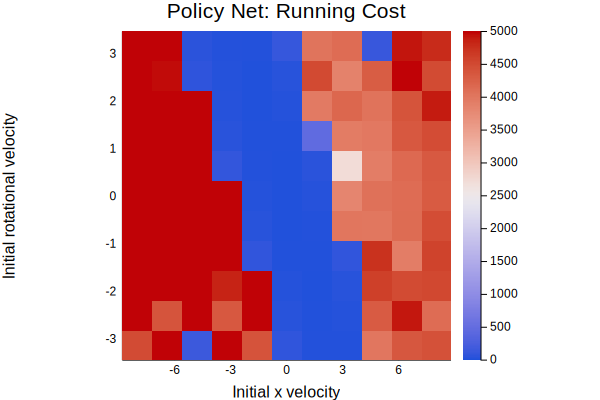

In [129]:
label = "Policy Net"
plt = cost_heatmap(cost_table, label)
title!(plt, "Policy Net: Running Cost")
savefig(plt, "policy_net_running_cost.pdf")
plt

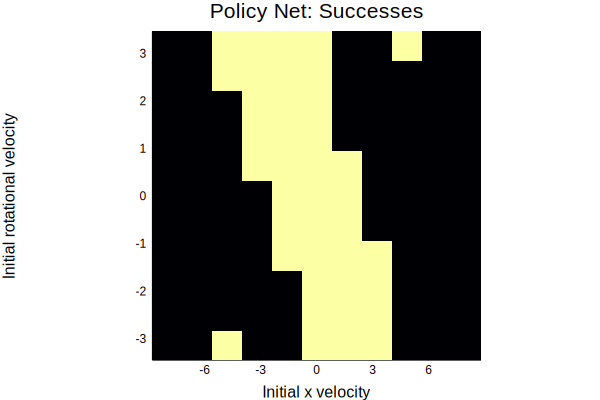

In [130]:
plt = success_heatmap(cost_table, label)
title!(plt, "Policy Net: Successes")
savefig(plt, "policy_net_successes.pdf")
plt

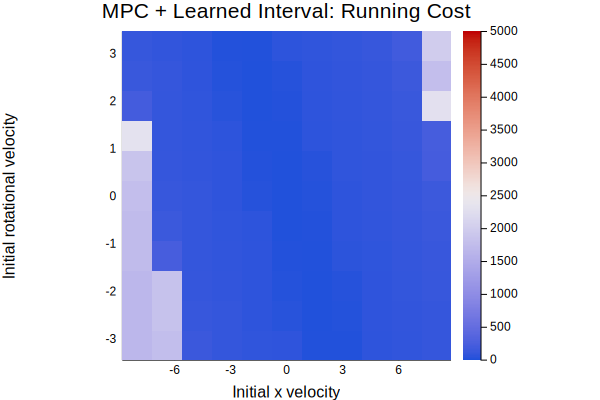

In [131]:
label = "MPC + Learned Interval"
plt = cost_heatmap(cost_table, label)
title!(plt, "MPC + Learned Interval: Running Cost")
savefig(plt, "mpc_interval_running_cost.pdf")
plt

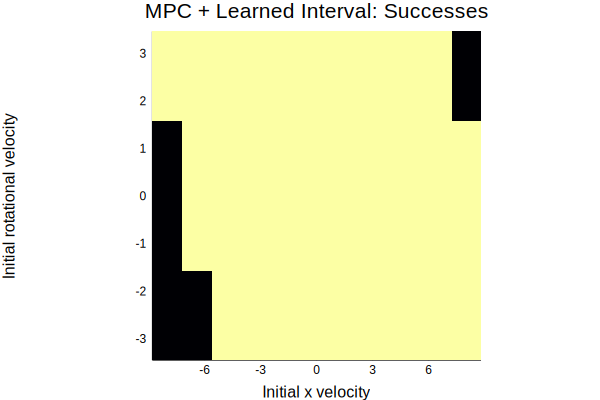

In [132]:
plt = success_heatmap(cost_table, label)
title!(plt, "MPC + Learned Interval: Successes")
savefig(plt, "mpc_interval_successes.pdf")
plt

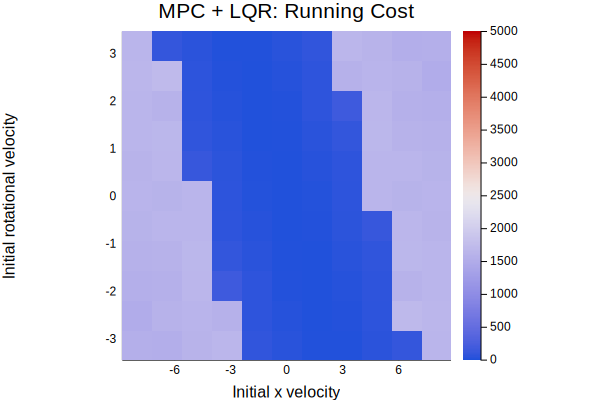

In [133]:
label = "MPC + LQR cost"
plt = cost_heatmap(cost_table, label)
title!(plt, "MPC + LQR: Running Cost")
savefig(plt, "mpc_lqr_running_cost.pdf")
plt

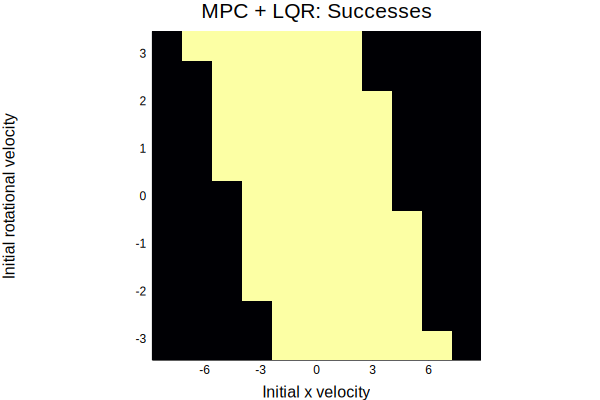

In [134]:
plt = success_heatmap(cost_table, label)
title!(plt, "MPC + LQR: Successes")
savefig(plt, "mpc_lqr_successes.pdf")
plt